#### **Import libraries**

In [244]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats

np.random.seed(777) # For reproducibility

#### **1. Generate synthetic data**

**Define helper-function for synthetic data**

In [245]:
def synthetic_data(qtd_sensors, num_examples, residaul_type = 'normal'):
    """Generate y = Xw + b + noise."""
    data_final = []
    for i in range(qtd_sensors):
        if residaul_type == 'normal':
            X = np.random.normal(i, 0.1, (num_examples, 1))
        elif residaul_type == 'uniform':
            X = np.random.rand(num_examples, 1)
        elif residaul_type == 'log_normal':
            X = np.random.lognormal(i, 0.5, (num_examples, 1))
        
        data_final.append(X)
    
    return np.concatenate(data_final, axis=1)

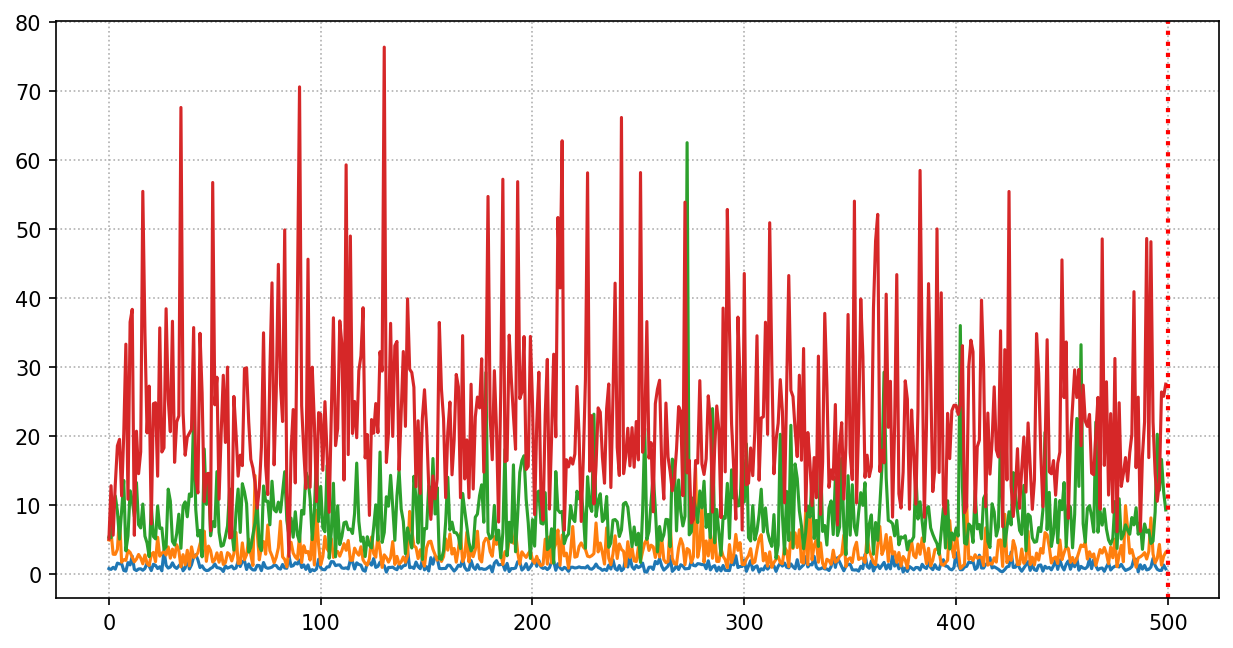

In [246]:
# Case #1: No error under normal dist.
# IDX_NORMAL, residaul_type = 700, 'normal' # First dataset is normal

# Case #2: Outlier exists under normal dist.
# IDX_NORMAL, residaul_type = 690, 'normal' # First dataset is normal

# Case #3: No error under uniform dist.
# IDX_NORMAL, residaul_type = 700, 'uniform' # First dataset is normal

# Case #4: Outlier exists under log-normal dist.
# IDX_NORMAL, residaul_type = 690, 'uniform' # First dataset is normal

# Case #5: No error under log-normal dist.
IDX_NORMAL, residaul_type = 700, 'log_normal' # First dataset is normal

# Case #6: Outlier exists under uniform dist.
IDX_NORMAL, residaul_type = 500, 'log_normal' # First dataset is normal

X0 = synthetic_data(4, IDX_NORMAL, residaul_type)


SIZE_ALL = X0.shape[0]

# Plot
if IDX_NORMAL < X0.shape[0]:
    for ind in range(X0.shape[1]):
        print('offset')
        X0[IDX_NORMAL::, ind] = X0[IDX_NORMAL::, ind] + np.random.normal(0.8, 0.001, (X0.shape[0]-IDX_NORMAL, 1)).reshape(1, -1)

# Plot
if 1:
    plt.figure(figsize = (10, 5), dpi =150)
    plt.plot(X0)
    plt.axvline(IDX_NORMAL, linestyle = ':', color = 'red', linewidth = 2)
    plt.grid(linestyle = ':')
    plt.show()

#### **2. Perform scaler**

**Since PCA is scale-sensitive in its range, scaler should be applied to dataset**

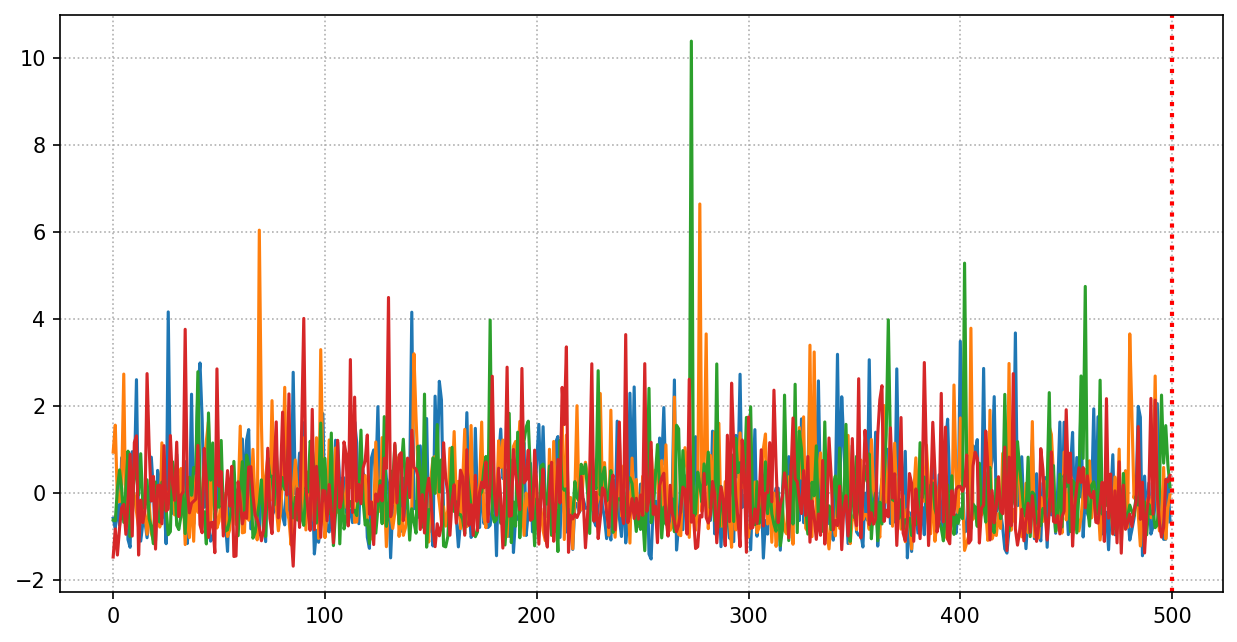

In [247]:
# Define standardizer (scaling)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X0)

# Get samples from baseline (Normal data)
if 1:
    plt.figure(figsize = (10, 5), dpi =150)
    plt.plot(X_scaled)
    plt.axvline(IDX_NORMAL, linestyle = ':', color = 'red', linewidth = 2)
    plt.grid(linestyle = ':')
    plt.show()

#### **3. Define anomaly detection model: PCA**

**Define helper-function for Anomaly detection based-on PCA**

In [248]:
from sklearn.decomposition import PCA

def perform_PCA_given_data(X):
    '''
        - Input
            X : Normalzied training samples [N(# samples)-by-f(# features)]

        - Output
            pca: fitted PCA model
            explVar: exaplined variance for PCs
            V: principal compoent vectors
            n_comp: # retained PCs
    '''
    pca = PCA().fit(X)

    # Explained variance of each features for PCA
    S = pca.explained_variance_
    
    # Retained PCs
    V = pca.components_

    return pca, S, V

pca, S, V = perform_PCA_given_data(X_scaled)

**Plot exlained PCs**

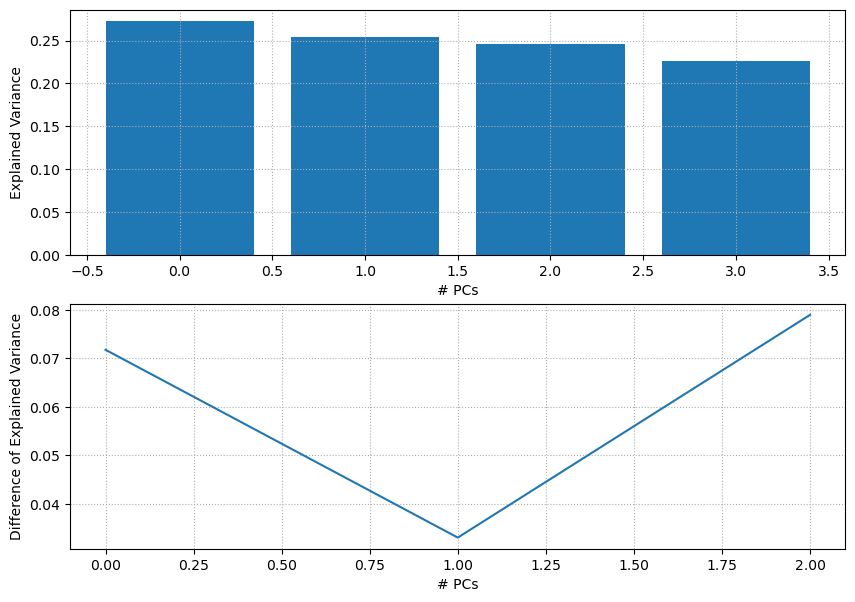

In [249]:
fig, ax = plt.subplots(2, 1, figsize = (10, 7))
# ax[0].bar(np.arange(0, S.shape[0]), S)
ax[0].bar(np.arange(0, S.shape[0]), S / sum(S))
ax[0].set_xlabel('# PCs')
ax[0].set_ylabel('Explained Variance')
ax[0].grid(linestyle = ':')


ax[1].plot(np.arange(0, S.shape[0]-1), np.abs(np.diff(S)))
# ax[1].plot(n_comp, np.abs(np.diff(S))[n_comp], 'bo', label = 'Optimal # PC')
ax[1].set_xlabel('# PCs')
ax[1].set_ylabel('Difference of Explained Variance')
ax[1].grid(linestyle = ':')
# ax[1].legend()
plt.show()

#### **Evaluation Step (Monitoring Phase)**

**Define Significance level**

In [250]:
alpha = 0.95

**Select optimal # of PCs: eigengap technique**

> **Ref.1) The rotation of eigenvectors by a perturbation (1970)**
> 
> **Ref.2) Adaptive data-derived anomaly detection in the activated... (2016)**

In [251]:
# Ref. 2)
n_comp = np.argmax(np.abs(np.diff(S))) + 1
n_comp

3

#### **1. Q-Statistic**
Q- residual indicates how well each sample conforms to the PCA model. 
- It is a measure of the difference, or residual between a sample and its projection into the principal components retained in the model.

$$
    Q(X, P_{1:r}) = X(I - P_{1:r}P_{1:r}^T)X^T = \| X - \hat{X} \|^2
$$

where $\hat{X} = P_{1:r} X$
- X: Normalized X
- P: Principal component (PC) vectors
- r: # of retained PCs

*Compute Q-Statistics*

In [252]:
# V[:n_comp]
def compute_Q_statistics(X, V_comp):
    
    Q = np.sqrt(np.sum(
    (X - np.matmul(np.matmul(X, V_comp.T), V_comp))**2
    , axis = 1))
    
    return Q

*Compute threshold of Q-Statistics*

$$
    Q_{alpha} = \frac{\theta_2}{2 \theta_1}\chi_{\alpha}^2(h)
$$

where 
- $\theta_1$: sample mean
- $\theta_2$: sample variance
- $\chi_{\alpha}^2(h)$: chi-squared distribution with $h$ degree of freedom and the significance level $\alpha$
- $h = \frac{2\theta_1^2}{\theta_2}$

> Note it is based on normality assumption on Q-statistics

In [253]:
from scipy.stats.distributions import chi2

def compute_Q_statistics_via_assumption(Q, alpha = 0.95):
    theta1 = np.mean(Q)
    theta2 = np.var(Q)
    h = 2 * (theta1 ** 2) / theta2
    chi_h = chi2.ppf(alpha, df=h)
    Qlimit = theta2/(2*theta1) * chi_h
    
    return Qlimit

- Conformal prediction => stoppting criteria => based on significance level (alpha)

In [254]:
alpha = 0.95
n_comp = 1

# Select optimal # of PCs: eigengap technique
# % ref.1) The rotation of eigenvectors by a perturbation (1970)
# % ref.2) Adaptive data-derived anomaly detection in the activated... (2016)
n_comp = np.argmax(np.abs(np.diff(S)))
n_comp

2

#### **1) Previous approach via Gaussian residual assumption**

In [255]:
Q_previous = compute_Q_statistics(X_scaled, V[:n_comp])
Qlim_previous = compute_Q_statistics_via_assumption(Q_previous, alpha)

#### **2) Proposed method via data-centric learning using conformal prediction**

In [256]:
Q_proposed, T2_list = [], []

for i in range(X_scaled.shape[0]):
    # Leave-one-out sampling
    Xtrain_subset = np.delete(X_scaled, i, axis=0)
    X_loo = X_scaled[i, :].reshape(1, -1)
    pca, S, V = perform_PCA_given_data(Xtrain_subset)

    # Compute Q-Statistics
    Q_loo = compute_Q_statistics(X_loo, V[:n_comp])
    
    Q_proposed.append(Q_loo)

Q_proposed = np.array(Q_proposed)

In [257]:
def summary_and_plot_result(Q, Qlim, title_string):
    plt.figure(figsize = (10, 3), dpi = 200)
    x = np.arange(0, Q.shape[0])
    plt.plot(x, Q, '.')
    outliers = Q >= Qlim
    plt.plot(x[outliers], Q[outliers], 'r.')
    a = plt.axhline(Qlim, color = 'r', linestyle = '-', label = f"{Qlim:.3f}")
    plt.grid(linestyle = ':')
    plt.legend()
    plt.title(title_string)
    plt.show()

    print("Q_{limit}: %.3f" % (Qlim))
    coverage_previous = (Q < Qlim).sum()/Q.shape[0]*100
    print(f"Coverage (%): {coverage_previous} ({outliers.sum()}/{Q.shape[0]}*100)")

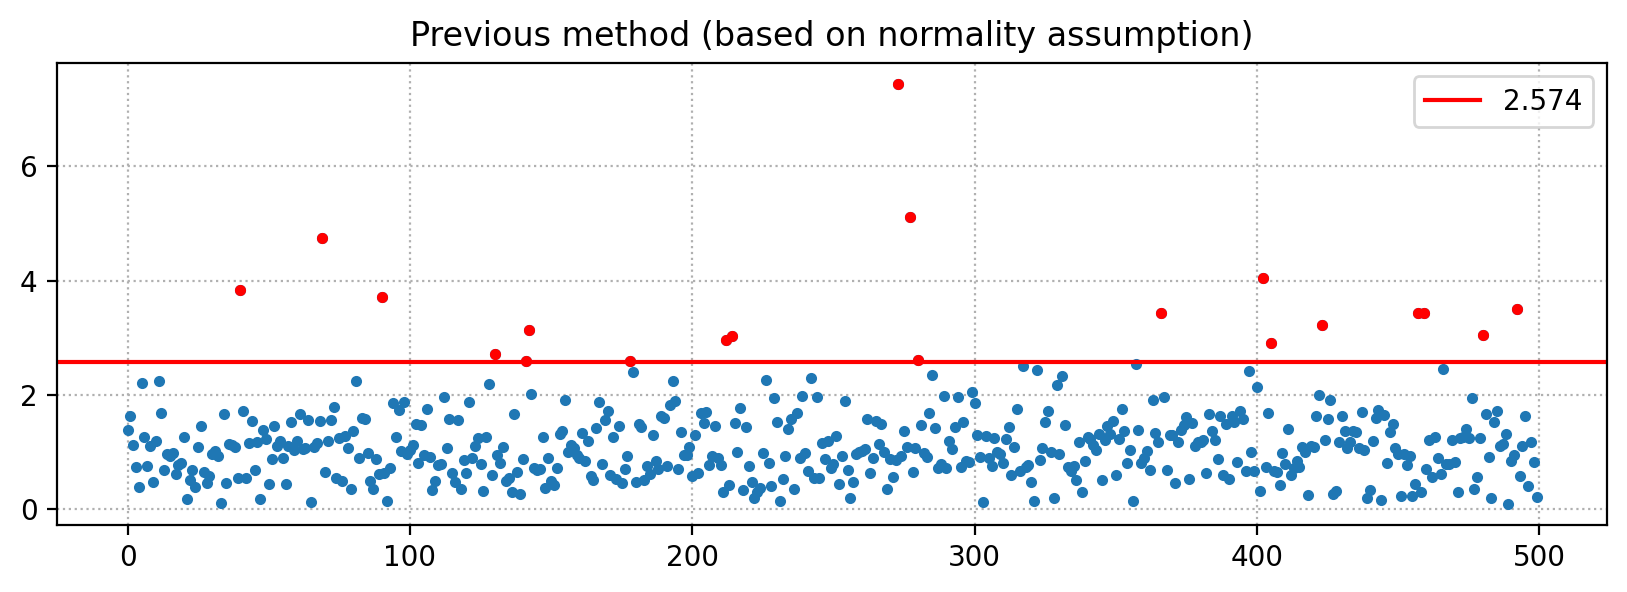

Q_{limit}: 2.574
Coverage (%): 96.0 (20/500*100)


In [258]:
title_string='Previous method (based on normality assumption)'
summary_and_plot_result(Q_previous, Qlim_previous, title_string)

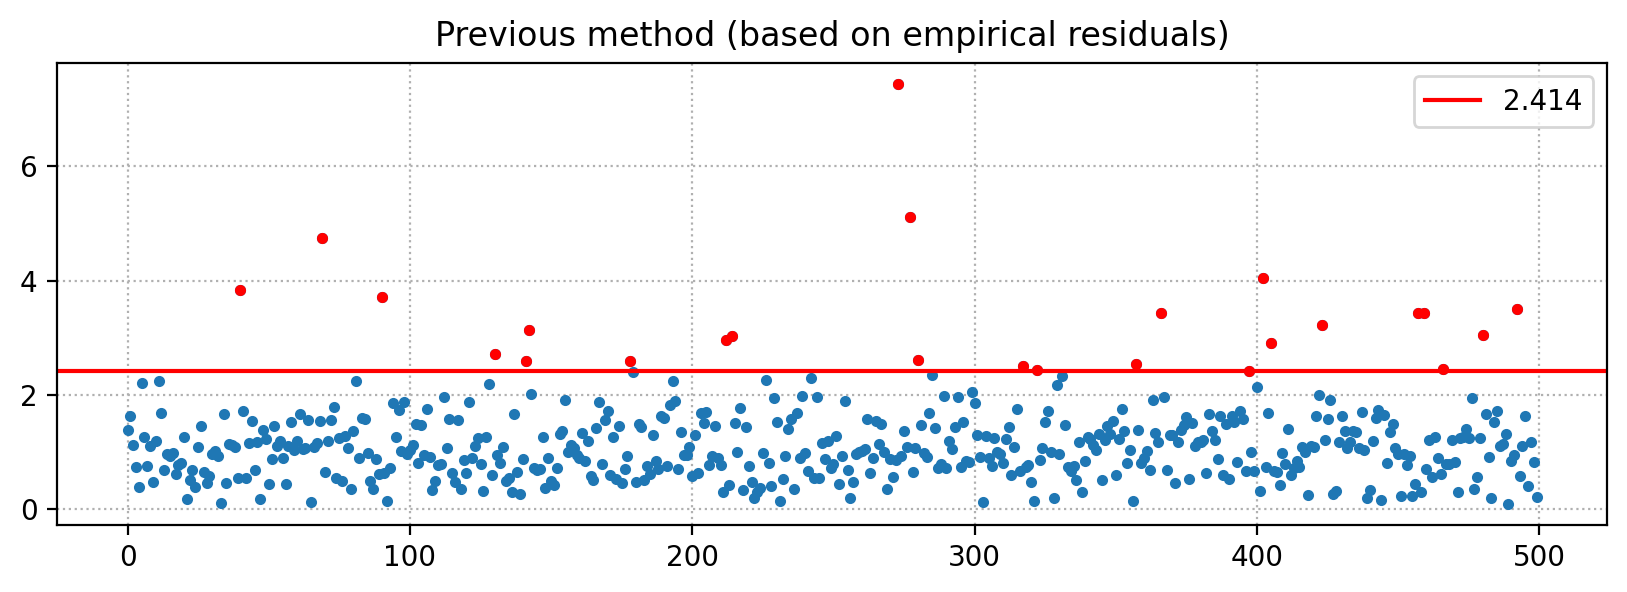

Q_{limit}: 2.414
Coverage (%): 95.0 (25/500*100)


In [259]:
Qlim_empirical = np.quantile(Q_previous, alpha, method="higher")

title_string='Previous method (based on empirical residuals)'
summary_and_plot_result(Q_previous, Qlim_empirical, title_string)

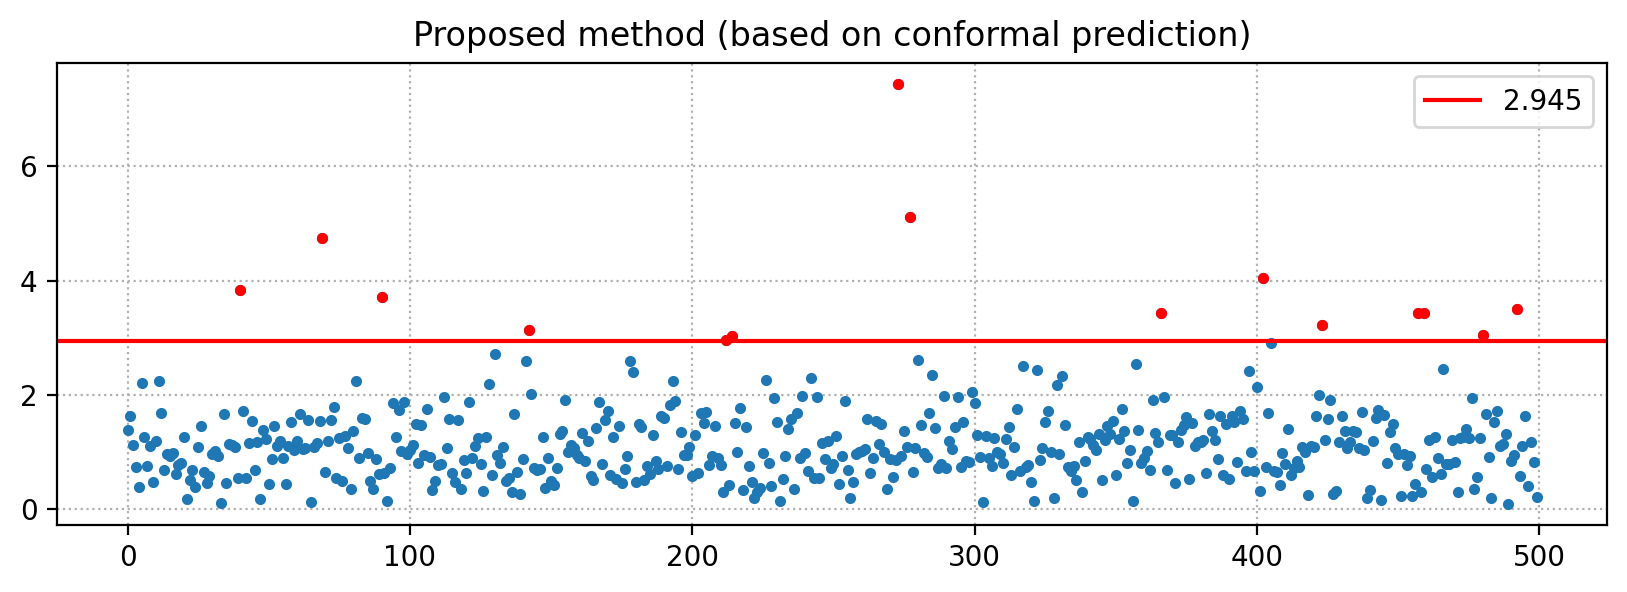

Q_{limit}: 2.945
Coverage (%): 97.0 (15/500*100)


In [260]:
emperical_quantile = alpha * (1 + (1 / Q_proposed.shape[0]))
Qlim_proposed = np.quantile(Q_proposed, emperical_quantile, method="higher")

title_string='Proposed method (based on conformal prediction)'
summary_and_plot_result(Q_previous, Qlim_proposed, title_string)